In [9]:
!pip install opendatasets --quiet

# 1. Importing the dependencies

In [141]:
# Importing the dependencies

import opendatasets as od
import pandas as pd
import numpy as np
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # for data visualization
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE # to address class imbalances
from sklearn.model_selection import train_test_split, cross_val_score # to split the data into training and testing sets and to cross validate our model later on
from sklearn.tree import DecisionTreeClassifier # model 1 chosen
from sklearn.ensemble import RandomForestClassifier # model 2 chosen
from xgboost import XGBClassifier # model 3 chosen
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
from sklearn.preprocessing import OneHotEncoder

# 2. Data loading and understanding

In [24]:
od.download("https://www.kaggle.com/datasets/blastchar/telco-customer-churn")

Skipping, found downloaded files in "./telco-customer-churn" (use force=True to force download)


In [27]:
df = pd.read_csv("telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [39]:
df.shape # checking the number of rows and columns in the dataframe

(7043, 21)

In [35]:
df.info() # understanding the data in the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [57]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [61]:
# printing the unique values in all the columns

for col in df.columns:
    print(col,df[col].unique())
    print("-"*50)

gender ['Female' 'Male']
--------------------------------------------------
SeniorCitizen [0 1]
--------------------------------------------------
Partner ['Yes' 'No']
--------------------------------------------------
Dependents ['No' 'Yes']
--------------------------------------------------
tenure [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
--------------------------------------------------
PhoneService ['No' 'Yes']
--------------------------------------------------
MultipleLines ['No phone service' 'No' 'Yes']
--------------------------------------------------
InternetService ['DSL' 'Fiber optic' 'No']
--------------------------------------------------
OnlineSecurity ['No' 'Yes' 'No internet service']
--------------------------------------------------
OnlineBackup ['Yes' 'No' 'No internet service']
-------

## Data preprocessing ##

The column TotalCharges is supposed to be a numerical column but it is of string type. So we should convert it.

In [65]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

ValueError: could not convert string to float: ' '

We get this error because there are some values in that column that are " ". These should be investigated.

In [70]:
df[df["TotalCharges"]==" "]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


The " " values here should be converted to 0.

df["TotalCharges"] = df["TotalCharges"].replace({" ":"0.0"})

In [79]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

It's adviced to convert all "object" type columns into "category" type if they are categorical values.

In [81]:
df[df.select_dtypes(include="object").columns] = df.select_dtypes(include="object").astype("category")

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   gender            7043 non-null   category
 1   SeniorCitizen     7043 non-null   int64   
 2   Partner           7043 non-null   category
 3   Dependents        7043 non-null   category
 4   tenure            7043 non-null   int64   
 5   PhoneService      7043 non-null   category
 6   MultipleLines     7043 non-null   category
 7   InternetService   7043 non-null   category
 8   OnlineSecurity    7043 non-null   category
 9   OnlineBackup      7043 non-null   category
 10  DeviceProtection  7043 non-null   category
 11  TechSupport       7043 non-null   category
 12  StreamingTV       7043 non-null   category
 13  StreamingMovies   7043 non-null   category
 14  Contract          7043 non-null   category
 15  PaperlessBilling  7043 non-null   category
 16  PaymentMethod     7043 n

In [87]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

## Checking the distribution of the target column ##

In [95]:
print(df["Churn"].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


There is a clear class imbalance and this must be dealt with using up/downsampling.

# 3. Exploratory Data Analysis #

In [100]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


Understanding the distribution of the numerical columns

In [107]:
def plot_histogram(df,column_name):
    plt.figure(figsize=(5,3))
    sns.histplot(df[column_name],kde=True)
    plt.title(f"Distibution of {column_name}")
    col_mean = df[column_name].mean() # calculating the mean of the column
    col_median = df[column_name].median() # calculating the median of the column
    plt.axvline(col_mean,color="red",linestyle="--",label="Mean") # adding a vertical line to indicate mean
    plt.axvline(col_median,color="blue",linestyle="--",label="Median") # adding a vertical line to indicate median
    plt.legend()
    plt.show()

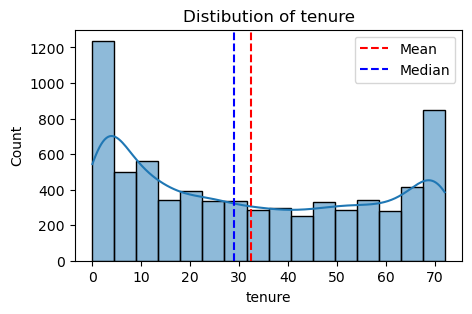

In [109]:
plot_histogram(df,"tenure")

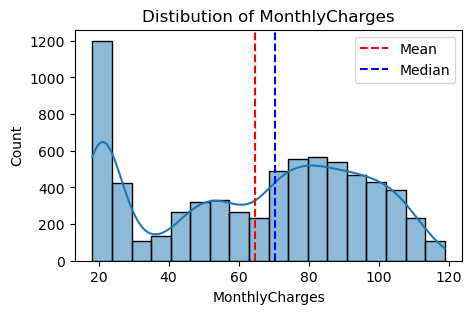

In [111]:
plot_histogram(df,"MonthlyCharges")

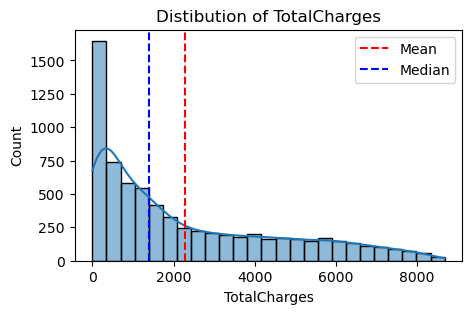

In [113]:
plot_histogram(df,"TotalCharges")

Checking the boxplot for each feature to further understand the numerical columns

In [116]:
def plot_boxplot(df,column_name):
    plt.figure(figsize=(5,3))
    sns.boxplot(y=df[column_name])
    plt.title(f"Distribution of {column_name}")
    plt.ylabel(column_name)
    plt.show()

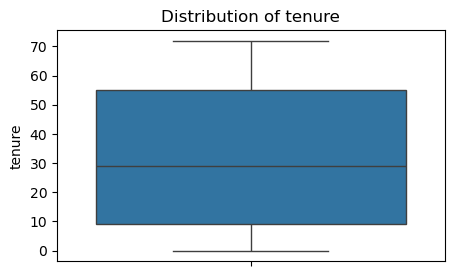

In [118]:
plot_boxplot(df,"tenure")

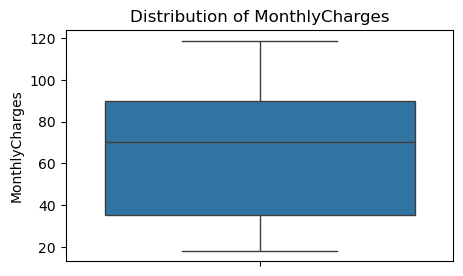

In [120]:
plot_boxplot(df,"MonthlyCharges")

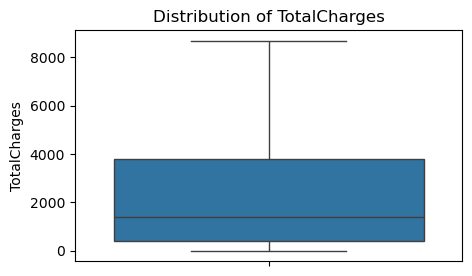

In [122]:
plot_boxplot(df,"TotalCharges")

Checking the correlation heatmap for the numerical columns

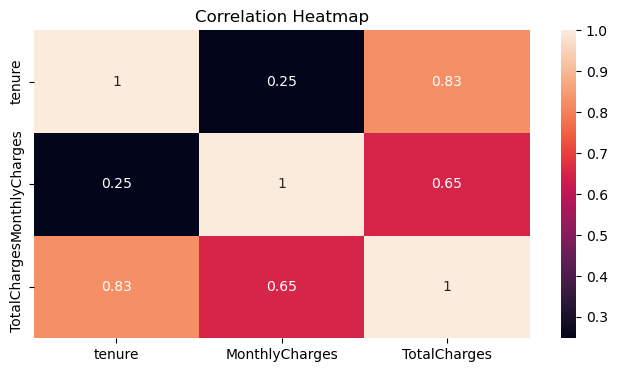

In [131]:
plt.figure(figsize=(8,4))
sns.heatmap(df[["tenure","MonthlyCharges","TotalCharges"]].corr(),annot=True)
plt.title("Correlation Heatmap")
plt.show()

### Analyzing the distribution of categorical columns ###

In [136]:
cat_cols = df.select_dtypes(include="category").columns.to_list()
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

Creating a countplot for the categorical columns to analysize their distribution

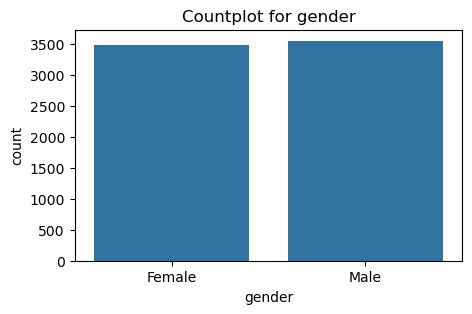

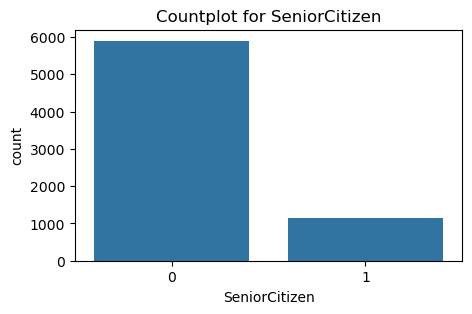

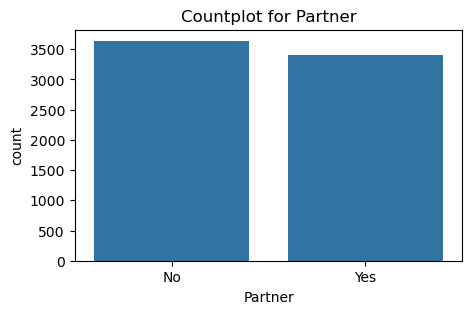

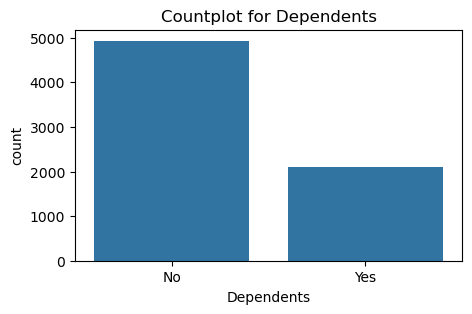

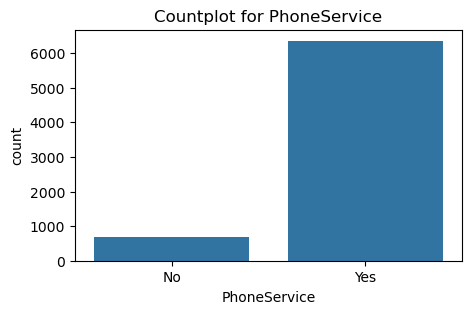

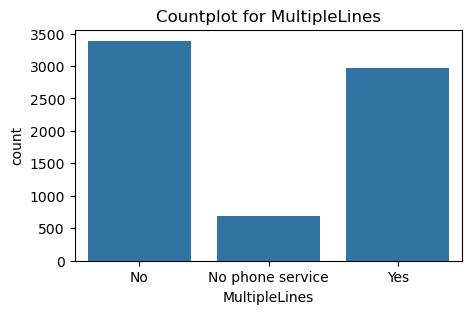

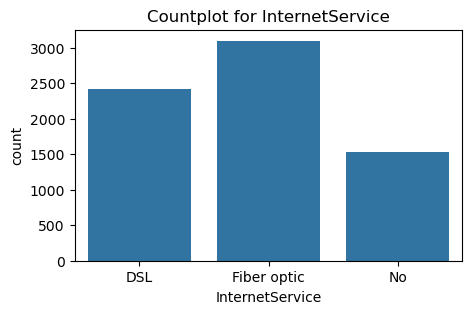

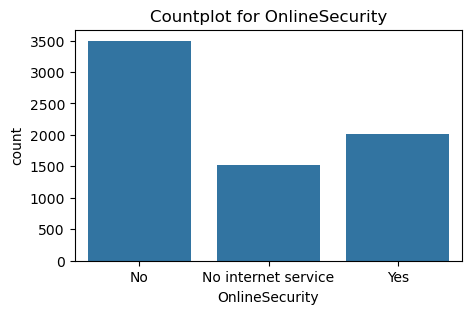

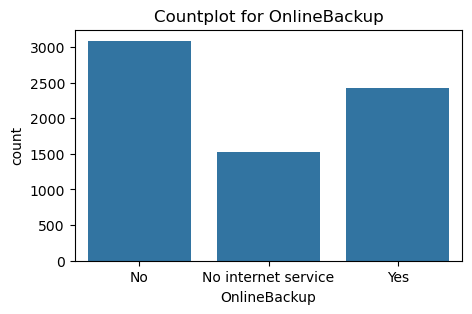

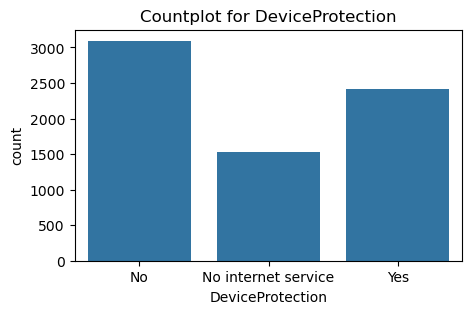

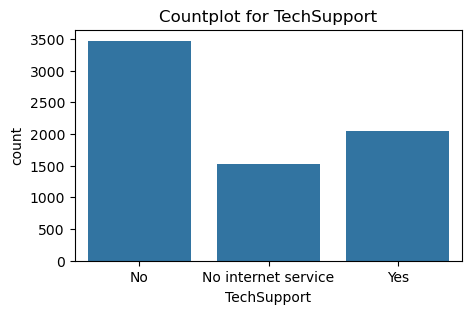

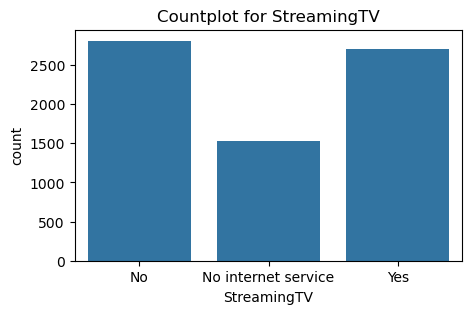

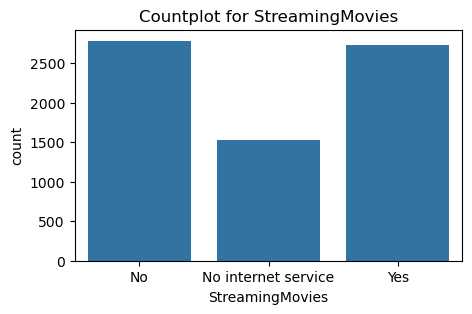

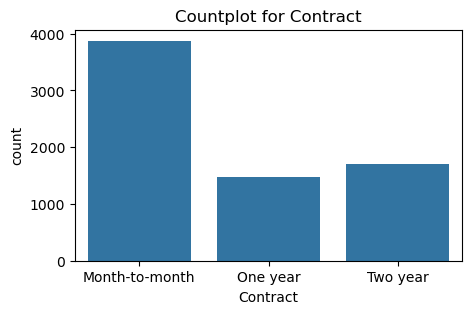

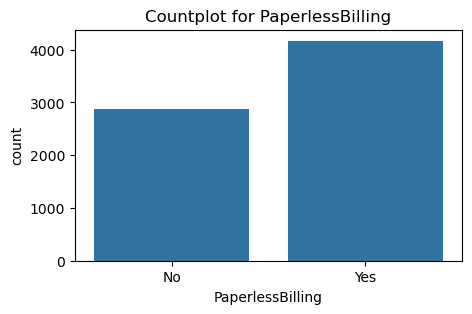

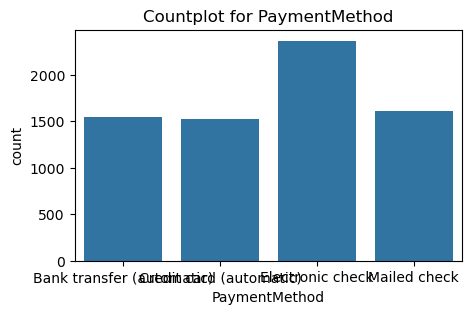

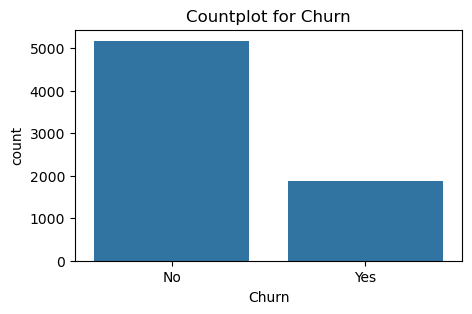

In [138]:
for col in cat_cols:
    plt.figure(figsize=(5,3))
    sns.countplot(x=df[col])
    plt.title(f"Countplot for {col}")              
    plt.show()

Encoding the categorical columns

In [144]:
encoders = {}

for col in cat_cols:
    label_encoder = LabelEncoder()
    df[col] = label_encoder.fit_transform(df[col])
    encoders[col] = label_encoder


with open("encoders.pkl","wb") as f:
    pickle.dump(encoders,f)

In [146]:
encoders

{'gender': LabelEncoder(),
 'SeniorCitizen': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder(),
 'Churn': LabelEncoder()}

In [148]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


## 4. Training and test data split ##

In [151]:
# Splitting the features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [155]:
# Splitting data into test and training splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 42)

In [157]:
print(y_train.value_counts())

Churn
0    4138
1    1496
Name: count, dtype: int64


To tackle the class imbalance, we can use SMOTE

In [160]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [162]:
print(y_train_smote.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


# 5. Model Training #

Training with default hyperparameters

In [168]:
# Dictionary of models
models = {
    "Decision Tree" : DecisionTreeClassifier(random_state = 42),
    "Random Forest" : RandomForestClassifier(random_state = 42),
    "XGBoost" : XGBClassifier(random_state = 42)
}

In [172]:
# Dictionary to store the cross validation results
cv_scores = {}

# Performing 5-fold cross validation for each model
for model_name, model in models.items():
    print(f"training {model_name} with default paramters")
    scores = cross_val_score(model, X_train_smote, y_train_smote, cv = 5, scoring = "accuracy")
    cv_scores[model_name] = scores
    print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")

training Decision Tree with default paramters
Decision Tree cross-validation accuracy: 0.78
training Random Forest with default paramters
Random Forest cross-validation accuracy: 0.84
training XGBoost with default paramters
XGBoost cross-validation accuracy: 0.83


In [182]:
cv_scores

{'Decision Tree': array([0.68055556, 0.71903323, 0.81752266, 0.84350453, 0.84048338]),
 'Random Forest': array([0.72826087, 0.77220544, 0.90453172, 0.89305136, 0.90030211]),
 'XGBoost': array([0.71074879, 0.75226586, 0.90271903, 0.89123867, 0.89909366])}

Since random forest gives us the highest accuracy.

In [193]:
random_forest_classifier = RandomForestClassifier(random_state = 42)

random_forest_classifier.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

# 6. Model Evaluation

Evaluate on test data

In [197]:
y_test_pred = model.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.7821149751596878
Confusion Matrix:
 [[876 160]
 [147 226]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      1036
           1       0.59      0.61      0.60       373

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409



The model's accuracy is low since there is a class imbalance, and therefore, the precision and recall scores are better metrics to observe

In [200]:
print(y_test.value_counts())

Churn
0    1036
1     373
Name: count, dtype: int64


In [211]:
# Saving the trained model as a pickle file
model_data = {"model":random_forest_classifier,"feature_names":X.columns.tolist()}

with open("customer_churn_model.pkl","wb") as f:
    pickle.dump(random_forest_classifier,f)

This model can be further improved on by maybe looking into hyper-parameter tuning and stratified k-fold cross validation